In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Concatenate, Dense, Dropout, 
                                      LayerNormalization, MultiHeadAttention, 
                                      Reshape, Flatten)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pickle
import time
import warnings

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

2025-10-26 07:56:06.203826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761465366.448246      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761465366.510663      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_PATH_EXP1 = '/kaggle/input/hybridvfl-exp-1/'
BASE_PATH_EXP2 = '/kaggle/input/hybridvfl-exp-2/'
BASE_PATH_EXP3 = '/kaggle/input/hybridvfl-exp-3/'

image_model = load_model(BASE_PATH_EXP1 + 'best_image_model.keras')

X_train = np.load(BASE_PATH_EXP1 + 'X_train.npy')
X_test = np.load(BASE_PATH_EXP1 + 'X_test.npy')
y_train = np.load(BASE_PATH_EXP1 + 'y_train.npy')
y_test = np.load(BASE_PATH_EXP1 + 'y_test.npy')

train_tabular_features = np.load(BASE_PATH_EXP2 + 'train_tabular_features.npy')
test_tabular_features = np.load(BASE_PATH_EXP2 + 'test_tabular_features.npy')

with open(BASE_PATH_EXP1 + 'class_weight_dict.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

with open(BASE_PATH_EXP2 + 'exp1_2_results.pkl', 'rb') as f:
    prev_results = pickle.load(f)

with open(BASE_PATH_EXP3 + 'exp3_results.pkl', 'rb') as f:
    exp3_results = pickle.load(f)

I0000 00:00:1761465379.553130      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
if hasattr(image_model, 'input') and image_model.input is not None:
    model_input = image_model.input
else:
    model_input = image_model.layers[0].input

feature_layer = None
for layer in image_model.layers:
    if isinstance(layer, tf.keras.layers.MaxPooling2D):
        feature_layer = layer
        if 'max_pooling2d_2' in layer.name:
            break

if feature_layer is None or 'max_pooling2d_2' not in feature_layer.name:
    maxpool_layers = [layer for layer in image_model.layers if isinstance(layer, tf.keras.layers.MaxPooling2D)]
    if len(maxpool_layers) >= 2:
        feature_layer = maxpool_layers[1]
    else:
        feature_layer = maxpool_layers[0]

base_image_model = Model(
    inputs=model_input,
    outputs=feature_layer.output,
    name='ImageBase'
)

for layer in base_image_model.layers:
    layer.trainable = False

In [4]:
image_input = Input(shape=(100, 100, 3), name='image_input')
base_features = base_image_model(image_input)
base_flat = Flatten(name='image_flatten')(base_features)

specific_img = Dense(2048, activation='relu', name='img_specific_dense1')(base_flat)
specific_img = Dropout(0.3, name='img_specific_dropout1')(specific_img)
specific_img_output = Dense(1024, activation='relu', name='img_specific_output')(specific_img)

invariant_img = Dense(512, activation='relu', name='img_invariant_dense1')(base_flat)
invariant_img = Dropout(0.2, name='img_invariant_dropout1')(invariant_img)
invariant_img_output = Dense(256, activation='relu', name='img_invariant_output')(invariant_img)

dual_image_client = Model(
    inputs=image_input,
    outputs=[specific_img_output, invariant_img_output],
    name='DualImageClient'
)

In [5]:
tabular_input = Input(shape=(train_tabular_features.shape[1],), name='tabular_input')

specific_tab = Dense(128, activation='relu', name='tab_specific_dense1')(tabular_input)
specific_tab = Dropout(0.3, name='tab_specific_dropout1')(specific_tab)
specific_tab_output = Dense(64, activation='relu', name='tab_specific_output')(specific_tab)

invariant_tab = Dense(128, activation='relu', name='tab_invariant_dense1')(tabular_input)
invariant_tab = Dropout(0.2, name='tab_invariant_dropout1')(invariant_tab)
invariant_tab_output = Dense(256, activation='relu', name='tab_invariant_output')(invariant_tab)

dual_tabular_client = Model(
    inputs=tabular_input,
    outputs=[specific_tab_output, invariant_tab_output],
    name='DualTabularClient'
)

In [6]:
spec_img_input = Input(shape=(1024,), name='server_spec_img_input')
inv_img_input = Input(shape=(256,), name='server_inv_img_input')
spec_tab_input = Input(shape=(64,), name='server_spec_tab_input')
inv_tab_input = Input(shape=(256,), name='server_inv_tab_input')

spec_img_proj = Dense(128, activation='relu', name='spec_img_proj')(spec_img_input)
spec_tab_proj = Dense(128, activation='relu', name='spec_tab_proj')(spec_tab_input)

spec_img_seq = Reshape((1, 128), name='spec_img_seq')(spec_img_proj)
spec_tab_seq = Reshape((1, 128), name='spec_tab_seq')(spec_tab_proj)

feature_sequence = Concatenate(axis=1, name='feature_sequence')([spec_img_seq, spec_tab_seq])

attention_layer = MultiHeadAttention(
    num_heads=4, 
    key_dim=32, 
    dropout=0.1,
    name='cross_modal_attention'
)
attended = attention_layer(feature_sequence, feature_sequence)

attended = LayerNormalization(epsilon=1e-6, name='attention_layernorm')(attended)

attended_flat = Flatten(name='attended_flatten')(attended)

final_features = Concatenate(name='final_features')([
    attended_flat,
    inv_img_input,
    inv_tab_input
])

x_server = Dense(4096, activation='relu', name='server_fc1')(final_features)
x_server = Dropout(0.5, name='server_dropout1')(x_server)
x_server = Dense(4096, activation='relu', name='server_fc2')(x_server)
x_server = Dropout(0.5, name='server_dropout2')(x_server)
server_output = Dense(7, activation='softmax', name='server_output')(x_server)

transformer_server = Model(
    inputs=[spec_img_input, inv_img_input, spec_tab_input, inv_tab_input],
    outputs=server_output,
    name='TransformerServer'
)

optimizer_img = Adam(learning_rate=0.0001)
optimizer_tab = Adam(learning_rate=0.0001)
optimizer_server = Adam(learning_rate=0.0001)

transformer_server.compile(
    optimizer=optimizer_server,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
VFL4_EPOCHS = 50
VFL4_BATCH_SIZE = 32
LAMBDA_ALIGNMENT = 0.5

num_train_samples = len(X_train)
num_batches = num_train_samples // VFL4_BATCH_SIZE

vfl4_train_loss_history = []
vfl4_train_acc_history = []
vfl4_val_loss_history = []
vfl4_val_acc_history = []
vfl4_class_loss_history = []
vfl4_align_loss_history = []
vfl4_comm_costs_upload = []
vfl4_comm_costs_download = []

vfl4_start_time = time.time()

print("Training Progress:")
for epoch in range(VFL4_EPOCHS):
    epoch_start = time.time()
    epoch_loss = 0
    epoch_class_loss = 0
    epoch_align_loss = 0
    epoch_acc = 0
    epoch_upload_cost = 0
    epoch_download_cost = 0
    
    indices = np.random.permutation(num_train_samples)
    
    for batch_idx in range(num_batches):
        batch_start = batch_idx * VFL4_BATCH_SIZE
        batch_end = batch_start + VFL4_BATCH_SIZE
        batch_indices = indices[batch_start:batch_end]
        
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        X_tab_batch = train_tabular_features[batch_indices]
        
        with tf.GradientTape(persistent=True) as client_tape:
            spec_img, inv_img = dual_image_client(X_batch, training=True)
            spec_tab, inv_tab = dual_tabular_client(X_tab_batch, training=True)
        
        upload_cost = (spec_img.numpy().nbytes + inv_img.numpy().nbytes + 
                       spec_tab.numpy().nbytes + inv_tab.numpy().nbytes) / (1024 * 1024)
        epoch_upload_cost += upload_cost
        
        with tf.GradientTape(persistent=True) as server_tape:
            predictions = transformer_server([spec_img, inv_img, spec_tab, inv_tab], training=True)
            
            sample_weights = np.array([class_weight_dict[np.argmax(y)] for y in y_batch])
            class_loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)
            class_loss = tf.reduce_mean(class_loss * sample_weights)
            
            alignment_loss = tf.reduce_mean(tf.square(inv_img - inv_tab))
            
            total_loss = class_loss + LAMBDA_ALIGNMENT * alignment_loss
        
        server_grads = server_tape.gradient(total_loss, transformer_server.trainable_variables)
        optimizer_server.apply_gradients(zip(server_grads, transformer_server.trainable_variables))
        
        grad_spec_img = server_tape.gradient(total_loss, spec_img)
        grad_inv_img = server_tape.gradient(total_loss, inv_img)
        grad_spec_tab = server_tape.gradient(total_loss, spec_tab)
        grad_inv_tab = server_tape.gradient(total_loss, inv_tab)
        
        del server_tape
        
        download_size = 0
        for grad in [grad_spec_img, grad_inv_img, grad_spec_tab, grad_inv_tab]:
            if grad is not None:
                download_size += grad.numpy().nbytes
        download_cost = download_size / (1024 * 1024)
        epoch_download_cost += download_cost
        
        if grad_spec_img is not None and grad_inv_img is not None:
            img_grads = client_tape.gradient(
                [spec_img, inv_img],
                dual_image_client.trainable_variables,
                output_gradients=[grad_spec_img, grad_inv_img]
            )
            if img_grads and any(g is not None for g in img_grads):
                optimizer_img.apply_gradients(zip(
                    [g for g in img_grads if g is not None],
                    [v for v, g in zip(dual_image_client.trainable_variables, img_grads) if g is not None]
                ))
        
        if grad_spec_tab is not None and grad_inv_tab is not None:
            tab_grads = client_tape.gradient(
                [spec_tab, inv_tab],
                dual_tabular_client.trainable_variables,
                output_gradients=[grad_spec_tab, grad_inv_tab]
            )
            if tab_grads and any(g is not None for g in tab_grads):
                optimizer_tab.apply_gradients(zip(
                    [g for g in tab_grads if g is not None],
                    [v for v, g in zip(dual_tabular_client.trainable_variables, tab_grads) if g is not None]
                ))
        
        del client_tape
        
        epoch_loss += total_loss.numpy()
        epoch_class_loss += class_loss.numpy()
        epoch_align_loss += alignment_loss.numpy()
        batch_acc = np.mean(np.argmax(predictions.numpy(), axis=1) == np.argmax(y_batch, axis=1))
        epoch_acc += batch_acc
    
    avg_loss = epoch_loss / num_batches
    avg_class_loss = epoch_class_loss / num_batches
    avg_align_loss = epoch_align_loss / num_batches
    avg_acc = epoch_acc / num_batches
    
    val_spec_img, val_inv_img = dual_image_client.predict(X_test, verbose=0)
    val_spec_tab, val_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
    val_predictions = transformer_server.predict([val_spec_img, val_inv_img, val_spec_tab, val_inv_tab], verbose=0)
    val_loss = tf.keras.losses.categorical_crossentropy(y_test, val_predictions).numpy().mean()
    val_acc = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_test, axis=1))
    
    vfl4_train_loss_history.append(avg_loss)
    vfl4_train_acc_history.append(avg_acc)
    vfl4_val_loss_history.append(val_loss)
    vfl4_val_acc_history.append(val_acc)
    vfl4_class_loss_history.append(avg_class_loss)
    vfl4_align_loss_history.append(avg_align_loss)
    vfl4_comm_costs_upload.append(epoch_upload_cost)
    vfl4_comm_costs_download.append(epoch_download_cost)
    
    # Print epoch progress
    print(f"Epoch {epoch+1}/{VFL4_EPOCHS} - loss: {avg_loss:.4f} - acc: {avg_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

vfl4_total_time = time.time() - vfl4_start_time

dual_image_client.save('/kaggle/working/exp4_dual_image_client.keras')
dual_tabular_client.save('/kaggle/working/exp4_dual_tabular_client.keras')
transformer_server.save('/kaggle/working/exp4_transformer_server.keras')

Training Progress:


I0000 00:00:1761465387.609868      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761465582.409944      59 service.cc:148] XLA service 0x7e47bc00c2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761465582.410578      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761465583.230870      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/50 - loss: 1.6424 - acc: 0.6088 - val_loss: 0.8715 - val_acc: 0.6657
Epoch 2/50 - loss: 1.3960 - acc: 0.6942 - val_loss: 0.7093 - val_acc: 0.7346
Epoch 3/50 - loss: 1.3230 - acc: 0.7300 - val_loss: 0.6831 - val_acc: 0.7410
Epoch 4/50 - loss: 1.2789 - acc: 0.7413 - val_loss: 0.6252 - val_acc: 0.7574
Epoch 5/50 - loss: 1.2461 - acc: 0.7543 - val_loss: 0.6526 - val_acc: 0.7548
Epoch 6/50 - loss: 1.2238 - acc: 0.7667 - val_loss: 0.5914 - val_acc: 0.7758
Epoch 7/50 - loss: 1.2049 - acc: 0.7766 - val_loss: 0.5777 - val_acc: 0.7877
Epoch 8/50 - loss: 1.1872 - acc: 0.7844 - val_loss: 0.6134 - val_acc: 0.7738
Epoch 9/50 - loss: 1.1775 - acc: 0.7900 - val_loss: 0.5823 - val_acc: 0.7849
Epoch 10/50 - loss: 1.1566 - acc: 0.7993 - val_loss: 0.5763 - val_acc: 0.7817
Epoch 11/50 - loss: 1.1427 - acc: 0.8060 - val_loss: 0.5357 - val_acc: 0.7973
Epoch 12/50 - loss: 1.1316 - acc: 0.8108 - val_loss: 0.5920 - val_acc: 0.7824
Epoch 13/50 - loss: 1.1295 - acc: 0.8104 - val_loss: 0.5164 - val_acc: 0.

In [8]:
test_spec_img, test_inv_img = dual_image_client.predict(X_test, verbose=0)
test_spec_tab, test_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
test_predictions = transformer_server.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)

y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

vfl4_test_acc = accuracy_score(y_true, y_pred)
vfl4_balanced_acc = balanced_accuracy_score(y_true, y_pred)
vfl4_macro_f1 = f1_score(y_true, y_pred, average='macro')
vfl4_macro_precision = precision_score(y_true, y_pred, average='macro')
vfl4_macro_recall = recall_score(y_true, y_pred, average='macro')

print(f"Test Accuracy: {vfl4_test_acc:.4f}")
print(f"Balanced Accuracy: {vfl4_balanced_acc:.4f}")
print(f"Macro F1: {vfl4_macro_f1:.4f}")
print(f"Macro Precision: {vfl4_macro_precision:.4f}")
print(f"Macro Recall: {vfl4_macro_recall:.4f}")

Test Accuracy: 0.8880
Balanced Accuracy: 0.9235
Macro F1: 0.8928
Macro Precision: 0.8732
Macro Recall: 0.9235


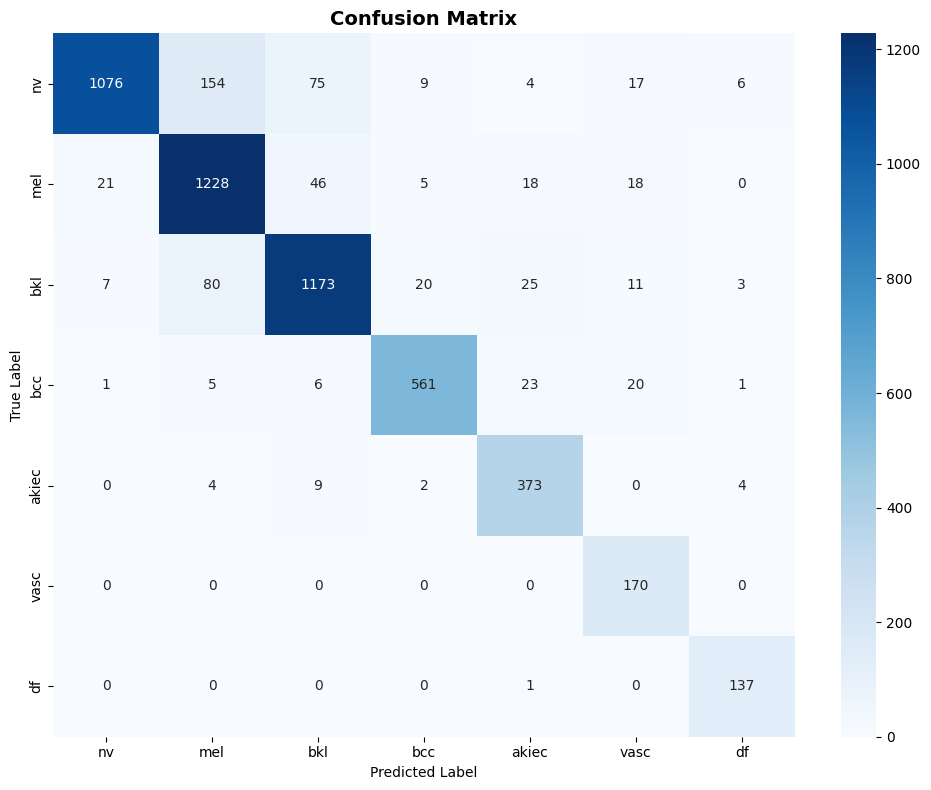

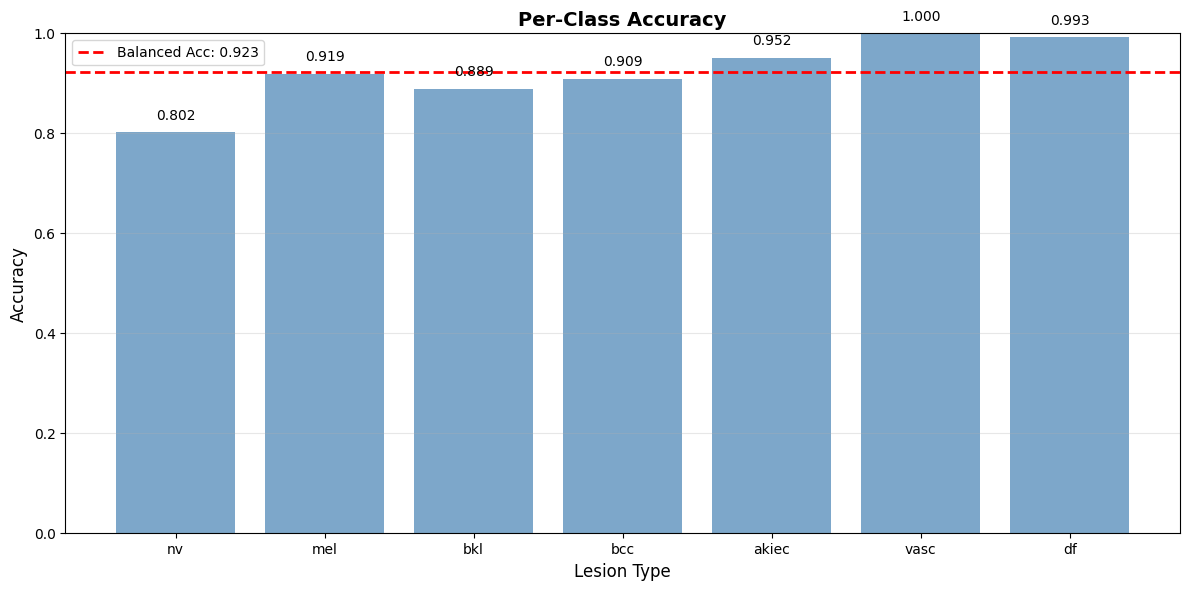

In [ ]:
lesion_types = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lesion_types, yticklabels=lesion_types)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/kaggle/working/exp4_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
bars = plt.bar(lesion_types, per_class_acc, color='steelblue', alpha=0.7)
plt.axhline(y=vfl4_balanced_acc, color='red', linestyle='--', linewidth=2, 
            label=f'Balanced Acc: {vfl4_balanced_acc:.3f}')
plt.xlabel('Lesion Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, per_class_acc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{acc:.3f}',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/exp4_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
inv_img_test_norm = test_inv_img / (np.linalg.norm(test_inv_img, axis=1, keepdims=True) + 1e-8)
inv_tab_test_norm = test_inv_tab / (np.linalg.norm(test_inv_tab, axis=1, keepdims=True) + 1e-8)

alignment_scores = np.sum(inv_img_test_norm * inv_tab_test_norm, axis=1)
avg_alignment = np.mean(alignment_scores)

exp4_results = {
    'test_accuracy': float(vfl4_test_acc),
    'balanced_accuracy': float(vfl4_balanced_acc),
    'confusion_matrix': cm,
    'training_history': {
        'loss': vfl4_train_loss_history,
        'acc': vfl4_train_acc_history,
        'val_loss': vfl4_val_loss_history,
        'val_acc': vfl4_val_acc_history,
        'class_loss': vfl4_class_loss_history,
        'align_loss': vfl4_align_loss_history,
        'comm_upload': vfl4_comm_costs_upload,
        'comm_download': vfl4_comm_costs_download
    },
    'per_class_accuracy': per_class_acc.tolist(),
    'predictions': y_pred,
    'alignment_stats': {
        'mean': float(avg_alignment),
        'min': float(alignment_scores.min()),
        'max': float(alignment_scores.max()),
        'std': float(alignment_scores.std())
    },
    'hyperparameters': {
        'lambda_alignment': LAMBDA_ALIGNMENT,
        'num_heads': 4,
        'key_dim': 32
    },
    'training_time_minutes': vfl4_total_time / 60,
    'architecture': 'cross_modal_transformer'
}

with open('/kaggle/working/exp4_results.pkl', 'wb') as f:
    pickle.dump(exp4_results, f)